# Supervised Learning Models for Anomaly-Based Intrusion Detection

This Jupyter Notebook focuses on training and evaluating supervised machine learning models for anomaly-based intrusion detection. It builds upon the preprocessed **CICIDS2017** dataset, prepared in the data preprocessing notebook.

The primary objective is to develop a prototype **Network Intrusion Detection System (NIDS)** capable of identifying a wide range of network attacks, such as **DoS, PortScan, and Brute Force**, while maintaining a balance between detection accuracy and computational efficiency. This balance is especially important for deployment in **resource-constrained environments**, which is a key focus of this project. The complete pipeline and implementation details are documented in the project’s GitHub repository.

## Models Being Evaluated

### Supervised Learning (This Notebook)
- Random Forest  
- k-Nearest Neighbors (k-NN)

## Evaluation Strategy

The models are evaluated using **k-fold cross-validation** on the training dataset, with a separate **hold-out test set** reserved for final performance assessment. The main evaluation metrics include:

- Accuracy  
- Precision  
- Recall  
- F1-score  
- Resource usage (CPU time and memory consumption)

These metrics provide valuable insights into both the **effectiveness** and **efficiency** of each model, which are critical requirements for real-time intrusion detection systems operating under limited resources.

This notebook presents the complete workflow for **model training, hyperparameter tuning, and comparative analysis** of the selected supervised learning algorithms.


In [24]:
# Importing the relevant libraries
import numpy as np 
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
import xgboost as xgb

from sklearn.preprocessing import RobustScaler
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import train_test_split, cross_val_score, RandomizedSearchCV
from sklearn.metrics import confusion_matrix, classification_report, accuracy_score, precision_score, recall_score, f1_score

from imblearn.under_sampling import RandomUnderSampler
from imblearn.over_sampling import SMOTE

import time
import psutil
import threading
import memory_profiler
from memory_profiler import memory_usage

import joblib

## Helper Functions

In [25]:
# Apply RF with resource measurements
def apply_rf(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5):
    """
    Apply Random Forest with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        best_params: Dictionary of best parameters for Random Forest.
        random_state: Random state for reproducibility.
        n_jobs: Number of jobs for parallel processing.
        cv: Number of cross-validation folds.

    Returns:
        cv_scores_rf: Cross-validation scores.
        measurement_rf: Dictionary of memory, training time, and CPU usage.
        rf_model: Trained Random Forest model.
    """
    
    measurement_rf = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    rf_model = RandomForestClassifier(**best_params, random_state=random_state, n_jobs=n_jobs)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        rf_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_rf = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_rf['Memory Usage (MB)'] = train_memory_rf
        measurement_rf['Training Time (s)'] = training_time
        measurement_rf['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_rf['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_rf = cross_val_score(rf_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_rf, measurement_rf, rf_model

    except Exception as e:
        print(f"Error during Random Forest training: {e}")
        return None, None, None


In [26]:
# Apply KNN with resource measurements
def apply_knn(X_train, y_train, best_params=None, n_jobs=-1, cv=5):
    """
    Apply K-Nearest Neighbors (KNN) with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels.
        best_params: Dictionary of best parameters for KNN.
        cv: Number of cross-validation folds.

    Returns:
        cv_scores_knn: Cross-validation scores.
        measurement_knn: Dictionary of memory, training time, and CPU usage.
        knn_model: Trained KNN model.
    """
    
    measurement_knn = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    # Initialize KNN model
    knn_model = KNeighborsClassifier(**best_params, n_jobs=n_jobs)

    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        knn_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_knn = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_knn['Memory Usage (MB)'] = train_memory_knn
        measurement_knn['Training Time (s)'] = training_time
        measurement_knn['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_knn['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_knn = cross_val_score(knn_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_knn, measurement_knn, knn_model

    except Exception as e:
        print(f"Error during KNN training: {e}")
        return None, None, None

In [67]:
# Apply XGBoost with resource measurements
def apply_xgboost(X_train, y_train, best_params=None, random_state=42, n_jobs=-1, cv=5):
    """
    Apply XGBoost with resource measurements, including memory, training time, and CPU usage.

    Parameters:
        X_train: Training features.
        y_train: Training labels (mapped).
        best_params: Dictionary of best parameters for XGBoost.
        random_state: Random state for reproducibility.
        n_jobs: Number of jobs for parallel processing.
        cv: Number of cross-validation folds.

    Returns:
        cv_scores_xgb: Cross-validation scores.
        measurement_xgb: Dictionary of memory, training time, and CPU usage.
        xgb_model: Trained XGBoost model.
    """
    
    measurement_xgb = {}

    # Default to empty dictionary if best_params is not provided
    best_params = best_params or {}

    xgb_model = xgb.XGBClassifier(**best_params, objective='multi:softmax', num_class=len(np.unique(y_train)), random_state=random_state, n_jobs=n_jobs)
    
    # Function to monitor CPU usage during training
    cpu_usage = []
    stop_flag = threading.Event()

    def monitor_cpu():
        while not stop_flag.is_set():
            cpu_usage.append(psutil.cpu_percent(interval=0.1))

    # Function to train the model
    def train_model():
        xgb_model.fit(X_train, y_train)

    try:
        # Start CPU monitoring in a separate thread
        cpu_thread = threading.Thread(target=monitor_cpu)
        cpu_thread.start()

        # Measure memory usage and training time
        start_time = time.time()
        train_memory_xgb = max(memory_usage((train_model,)))  # Measure peak memory usage
        training_time = time.time() - start_time

        # Stop CPU monitoring
        stop_flag.set()
        cpu_thread.join()

        # Add measurements
        measurement_xgb['Memory Usage (MB)'] = train_memory_xgb
        measurement_xgb['Training Time (s)'] = training_time
        measurement_xgb['Peak CPU Usage (%)'] = max(cpu_usage)
        measurement_xgb['Average CPU Usage (%)'] = sum(cpu_usage) / len(cpu_usage) if cpu_usage else 0

        # Perform cross-validation
        cv_scores_xgb = cross_val_score(xgb_model, X_train, y_train, cv=cv, n_jobs=n_jobs)

        return cv_scores_xgb, measurement_xgb, xgb_model

    except Exception as e:
        print(f"Error during XGBoost training: {e}")
        return None, None, None

## 1. Loading and Preparing

In [ ]:
# Loading the dataset
clean_df = pd.read_csv('..\data\cicids2017_cleaned.csv')

<>:2: SyntaxWarning: invalid escape sequence '\c'
<>:2: SyntaxWarning: invalid escape sequence '\c'
C:\Users\nadin\AppData\Local\Temp\ipykernel_32648\3159023911.py:2: SyntaxWarning: invalid escape sequence '\c'
  clean_df = pd.read_csv('D:\cs year 3\Cyber security\Intrusion Detection\data\cicids2017_cleaned.csv')


In [28]:
clean_df.head()

,Destination Port,Flow Duration,Total Fwd Packets,Total Length of Fwd Packets,Fwd Packet Length Max,Fwd Packet Length Min,Fwd Packet Length Mean,Fwd Packet Length Std,Bwd Packet Length Max,Bwd Packet Length Min,...,Init_Win_bytes_backward,act_data_pkt_fwd,min_seg_size_forward,Active Mean,Active Max,Active Min,Idle Mean,Idle Max,Idle Min,Attack Type
0,22,1266342,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
1,22,1319353,41,2664,456,0,64.975610,109.864573,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
2,22,160,1,0,0,0,0.000000,0.000000,0,0,...,243,0,32,0.0,0,0,0.0,0,0,Normal Traffic
3,22,1303488,41,2728,456,0,66.536585,110.129945,976,0,...,243,24,32,0.0,0,0,0.0,0,0,Normal Traffic
4,35396,77,1,0,0,0,0.000000,0.000000,0,0,...,290,0,32,0.0,0,0,0.0,0,0,Normal Traffic


### 1.1. Preparing Training and Test Sets

In [29]:
# Preparing training and test splits
X = clean_df.drop('Attack Type', axis=1)
y = clean_df['Attack Type']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=42, stratify=y)

#### 1.1.1. Feature Scaling

In [30]:
# Initialize RobustScaler
scaler = RobustScaler()

# Fit and transform the training data
X_train_scaled = scaler.fit_transform(X_train)

# Transform the test set using the fitted scaler
X_test_scaled = scaler.transform(X_test)

In [31]:
import os
import joblib
os.makedirs("../scalers", exist_ok=True)
joblib.dump(scaler, "../scalers/robust_scaler.joblib")


['../scalers/robust_scaler.joblib']

#### 1.1.2. Resampling Techniques

In [32]:
# Checking the distribution of the target variable
clean_df['Attack Type'].value_counts()

Attack Type
Normal Traffic    2095057
DoS                193745
DDoS               128014
Port Scanning       90694
Brute Force          9150
Web Attacks          2143
Bots                 1948
Name: count, dtype: int64

In [33]:
# Initializing the undersampling for the clean df
X_train_resampled, y_train_resampled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train, y_train)

# Initializing the undersampling for the scaled df
X_train_scaled, y_train_scaled = RandomUnderSampler(sampling_strategy={'Normal Traffic': 500000}, random_state=42).fit_resample(X_train_scaled, y_train)

In [34]:
# Initializing the oversampling for the scaled df
X_train_resampled_scaled, y_train_resampled_scaled = SMOTE(sampling_strategy={'Bots': 2000, 'Web Attacks': 2000, 'Brute Force': 7000, 'Port Scanning': 70000, 'DDoS':90000, 'DoS': 200000}, random_state=42).fit_resample(X_train_scaled, y_train_scaled)

In [35]:
# Cleaning up
del X_train_scaled, X_train, y_train, X, y, clean_df

In [14]:
# Checking the distribution of the attack types in the resampled/raw training set
y_train_scaled.value_counts()

Attack Type
Normal Traffic    500000
DoS               135621
DDoS               89610
Port Scanning      63486
Brute Force         6405
Web Attacks         1500
Bots                1364
Name: count, dtype: int64

In [36]:
# Checking the distribution of the attack types in the resampled/scaled training set
y_train_resampled_scaled.value_counts()

Attack Type
Normal Traffic    500000
DoS               200000
DDoS               90000
Port Scanning      70000
Brute Force         7000
Bots                2000
Web Attacks         2000
Name: count, dtype: int64

## 2. Supervised Learning

### 2.1. Random Forest

In [41]:
# # Defining the parameters for the Random Forest Classifier
# param_grid = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [20, 30, None],
#     'min_samples_split': [2, 5, 10],
#     'min_samples_leaf': [1, 2, 4],
#     'max_features': ['sqrt', 'log2'],
# }

In [ ]:
# #Creating the Random Forest Classifier
# rf_model = RandomForestClassifier(random_state=42, n_jobs=-1)

In [43]:
# # Saving results with the standard parameters
# cv_sc_rf = cross_val_score(rf_model, X_train_resampled, y_train_resampled, cv=2, n_jobs=2)
# cv_sc_rf = np.mean(cv_sc_rf)

# # Apply RandomizedSearchCV
# random_search_rf = RandomizedSearchCV(estimator=rf_model, param_distributions=param_grid, n_iter=5, cv=2, n_jobs=2, verbose=2)
# random_search_rf.fit(X_train_resampled, y_train_resampled)

In [ ]:
# # Get the best parameters
# print(f'Best Parameters: {random_search_rf.best_params_}')
# print(f"Best Cross-Validation Score: {random_search_rf.best_score_}")
# print(f"Cross-Validation from Standard: {cv_sc_rf}")

# best_params_rf = random_search_rf.best_params_ if random_search_rf.best_score_ > cv_sc_rf else None

# del random_search_rf

Best Parameters: {'n_estimators': 200, 'min_samples_split': 2, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}
Best Cross-Validation Score: 0.998605238688398
Cross-Validation from Standard: 0.9984335564784345


Best Parameters:

n_estimators: 200

min_samples_split: 5

min_samples_leaf: 2

max_features: 'sqrt'

max_depth: None

In [44]:
# Defining manually due to Kaggle performance limitations
best_params_rf = {'n_estimators': 200, 'min_samples_split': 5, 'min_samples_leaf': 2, 'max_features': 'sqrt', 'max_depth': None}

#### 2.1.2. Fitting the Random Forest

In [45]:
# Fitting the model
cv_scores_rf, measurement_rf, rf_model = apply_rf(X_train_resampled, y_train_resampled, best_params=best_params_rf)

# Making predictions
y_pred_rf = rf_model.predict(X_test)

In [56]:
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_rf = np.mean(cv_scores_rf)
print(f'Cross validation average score: {cv_scores_mean_rf:.4f} +/- standard deviation: {np.std(cv_scores_rf):.4f}')

accuracy_rf = accuracy_score(y_test, y_pred_rf)
print(f'Accuracy on the test set: {accuracy_rf:.4f}')

Cross validation average score: 0.9987 +/- standard deviation: 0.0001
Accuracy on the test set: 0.9988


In [57]:
# Checking computational cost
print("Resource measurements:", measurement_rf)

Resource measurements: {'Memory Usage (MB)': 1614.41796875, 'Training Time (s)': 105.98137927055359, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 95.90864381520119}


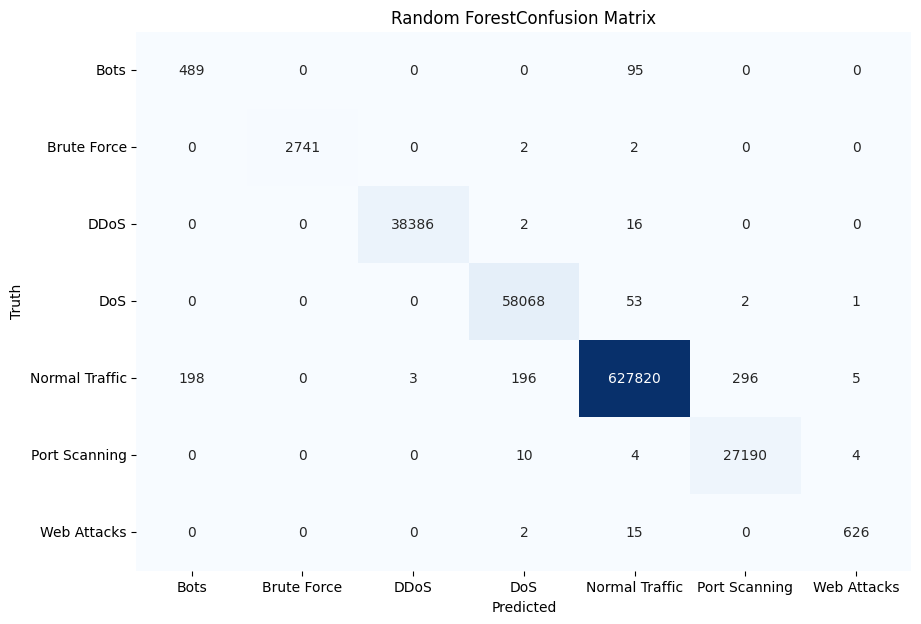

In [58]:
# Evaluating the model via confusion matrix
cm_rf = confusion_matrix(y_test, y_pred_rf)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_rf, annot=True, fmt='d', xticklabels=rf_model.classes_, yticklabels=rf_model.classes_, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('Random ForestConfusion Matrix')
plt.show()

In [59]:
# Classification report
print(classification_report(y_test, y_pred_rf))

                precision    recall  f1-score   support

          Bots       0.71      0.84      0.77       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.98      0.97      0.98       643

      accuracy                           1.00    756226
     macro avg       0.95      0.97      0.96    756226
  weighted avg       1.00      1.00      1.00    756226



#### 2.1.3. Exporting the Model

In [60]:
os.makedirs("../models", exist_ok=True)
joblib.dump(rf_model, "../models/random_forest.joblib")

['../models/random_forest.joblib']

### 2.2. XGBoost

#### 2.2.1. Hyperparameter Tuning*

In [61]:
# # Defining the parameter grid for XGBoost
# param_dist = {
#     'n_estimators': [100, 150, 200],
#     'max_depth': [3, 6, 9],
#     'learning_rate': [0.2, 0.3, 0.4],
#     'subsample': [0.7, 0.8, 1.0],
#     'colsample_bytree': [0.7, 0.8, 1.0],
#     'min_child_weight': [1, 5, 10],
# }

In [62]:
# # Creating the XGBoost Classifier
# xgb_model = xgb.XGBClassifier(objective='multi:softmax', num_class=len(y_train_resampled.unique()), random_state=42, n_jobs=-1)

# Custom mapping for the attack types
label_mapping = {
    'Normal Traffic': 0,
    'DoS': 1,
    'DDoS': 2,
    'Port Scanning': 3,
    'Brute Force': 4,
    'Web Attacks': 5,
    'Bots': 6
}
y_train_resampled_mapped = y_train_resampled.map(label_mapping)
y_test_mapped = y_test.map(label_mapping)

In [63]:
# # Saving results with the standard parameters
# cv_sc_xgb = cross_val_score(xgb_model, X_train_resampled, y_train_resampled_mapped, cv=3, n_jobs=-1)
# cv_sc_xgb = np.mean(cv_sc_xgb)

# # Perform RandomizedSearchCV
# random_search_xgb = RandomizedSearchCV(estimator=xgb_model, param_distributions=param_dist, n_iter=30, cv=3, n_jobs=-1, verbose=2, random_state=42)
# random_search_xgb.fit(X_train_resampled, y_train_resampled_mapped)

In [64]:
# # Best parameters found by RandomizedSearchCV
# print(f'Best Parameters for XGBoost: {random_search_xgb.best_params_}')
# print(f"Best Cross-Validation Score: {random_search_xgb.best_score_}")
# print(f"Cross-Validation from Standard: {cv_sc_xgb}")

# best_params_xgb = random_search_xgb.best_params_ if random_search_xgb.best_score_ > cv_sc_xgb else None

# del random_search_xgb

Best Parameters:

subsample: 1.0

n_estimators: 150

min_child_weight: 1

max_depth: 3

learning_rate: 0.3

colsample_bytree: 0.7

In [65]:
# Defining parameters manually due to Kaggles performance limitataions
best_params_xgb = {'subsample': 1.0, 'n_estimators': 150, 'min_child_weight': 1, 'max_depth': 3, 'learning_rate': 0.3, 'colsample_bytree': 0.7}

#### 2.2.2. Fitting the XGBoost

In [68]:
# Fitting the model
cv_scores_xgb, measurement_xgb, xgb_model = apply_xgboost(X_train_resampled, y_train_resampled_mapped, best_params=best_params_xgb)

# Making predictions
y_pred_xgb = xgb_model.predict(X_test)

In [69]:
# Evaluating the model performance on the cross validation set vs accuracy on the test set
cv_scores_mean_xgb = np.mean(cv_scores_xgb)
print(f'Cross validation average score: {cv_scores_mean_xgb:.4f} +/- standard deviation: {np.std(cv_scores_xgb):.4f}')

accuracy_xgb = accuracy_score(y_test_mapped, y_pred_xgb)
print(f'Accuracy on the test set: {accuracy_xgb:.4f}')

Cross validation average score: 0.9991 +/- standard deviation: 0.0000
Accuracy on the test set: 0.9990


In [70]:
# Checking computational cost
print("Resource measurements:", measurement_xgb)


Resource measurements: {'Memory Usage (MB)': 1123.046875, 'Training Time (s)': 27.348724365234375, 'Peak CPU Usage (%)': 100.0, 'Average CPU Usage (%)': 95.44247104247104}


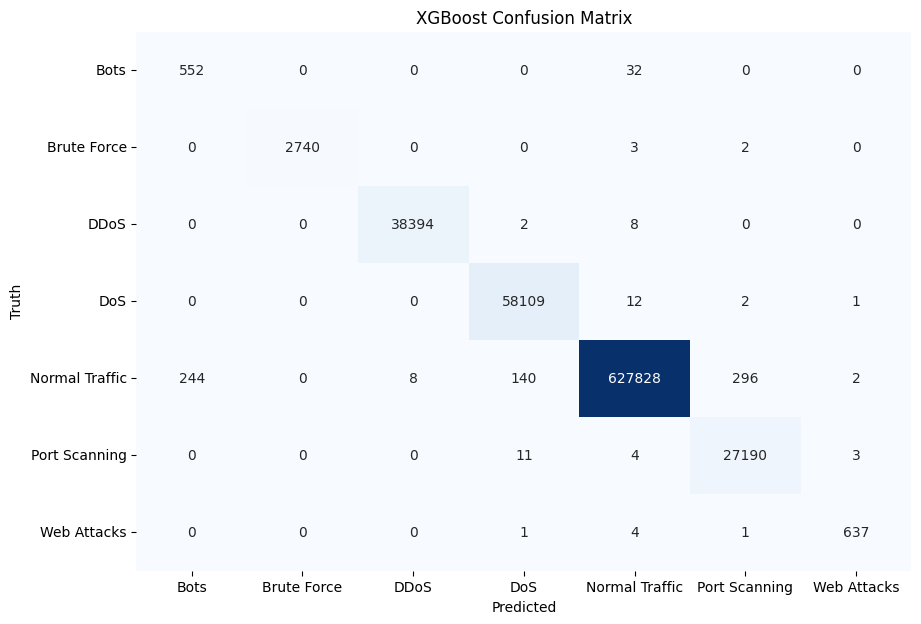

In [71]:
# Remapping the labels for visualization
reverse_label_mapping = {v: k for k, v in label_mapping.items()}
predicted_labels = [reverse_label_mapping[pred] for pred in y_pred_xgb]
actual_labels = sorted([reverse_label_mapping[label] for label in xgb_model.classes_])

# Confusion matrix
cm_xgb = confusion_matrix(y_test, predicted_labels)

plt.figure(figsize=(10, 7))
sns.heatmap(cm_xgb, annot=True, fmt='d', xticklabels=actual_labels, yticklabels=actual_labels, cmap='Blues', cbar=False)
plt.xlabel('Predicted')
plt.ylabel('Truth')
plt.title('XGBoost Confusion Matrix')
plt.show()

In [72]:
# Classification report
print(classification_report(y_test, predicted_labels))

                precision    recall  f1-score   support

          Bots       0.69      0.95      0.80       584
   Brute Force       1.00      1.00      1.00      2745
          DDoS       1.00      1.00      1.00     38404
           DoS       1.00      1.00      1.00     58124
Normal Traffic       1.00      1.00      1.00    628518
 Port Scanning       0.99      1.00      0.99     27208
   Web Attacks       0.99      0.99      0.99       643

      accuracy                           1.00    756226
     macro avg       0.95      0.99      0.97    756226
  weighted avg       1.00      1.00      1.00    756226



#### 2.2.3. Exporting the Model

In [73]:
joblib.dump(xgb_model, '../models/xgboost.joblib')

['../models/xgboost.joblib']

## 3. Comparing Performance Results

In [76]:
# Calculating precision, recall, and F1 score for each model
precision_rf = precision_score(y_test, y_pred_rf, average='weighted')
recall_rf = recall_score(y_test, y_pred_rf, average='weighted')
f1_rf = f1_score(y_test, y_pred_rf, average='weighted')

precision_xgb = precision_score(y_test_mapped, y_pred_xgb, average='weighted')
recall_xgb = recall_score(y_test_mapped, y_pred_xgb, average='weighted')
f1_xgb = f1_score(y_test_mapped, y_pred_xgb, average='weighted')

In [78]:
# Creating the results dataframe
supervised_results = pd.DataFrame({
    'Model': ['Random Forest', 'XGBoost'],
    'Accuracy': [accuracy_rf, accuracy_xgb],
    'Cross Validation Mean': [cv_scores_mean_rf, cv_scores_mean_xgb],
    'Precision': [precision_rf, precision_xgb],
    'Recall': [recall_rf, recall_xgb],
    'F1 Score': [f1_rf, f1_xgb],
    'Memory Usage (MB)': [measurement_rf['Memory Usage (MB)'], measurement_xgb['Memory Usage (MB)']],
    'Training Time (s)': [measurement_rf['Training Time (s)'], measurement_xgb['Training Time (s)']],
    'Peak CPU Usage (%)': [measurement_rf['Peak CPU Usage (%)'], measurement_xgb['Peak CPU Usage (%)']],
    'Average CPU Usage (%)': [measurement_rf['Average CPU Usage (%)'], measurement_xgb['Average CPU Usage (%)']],
})

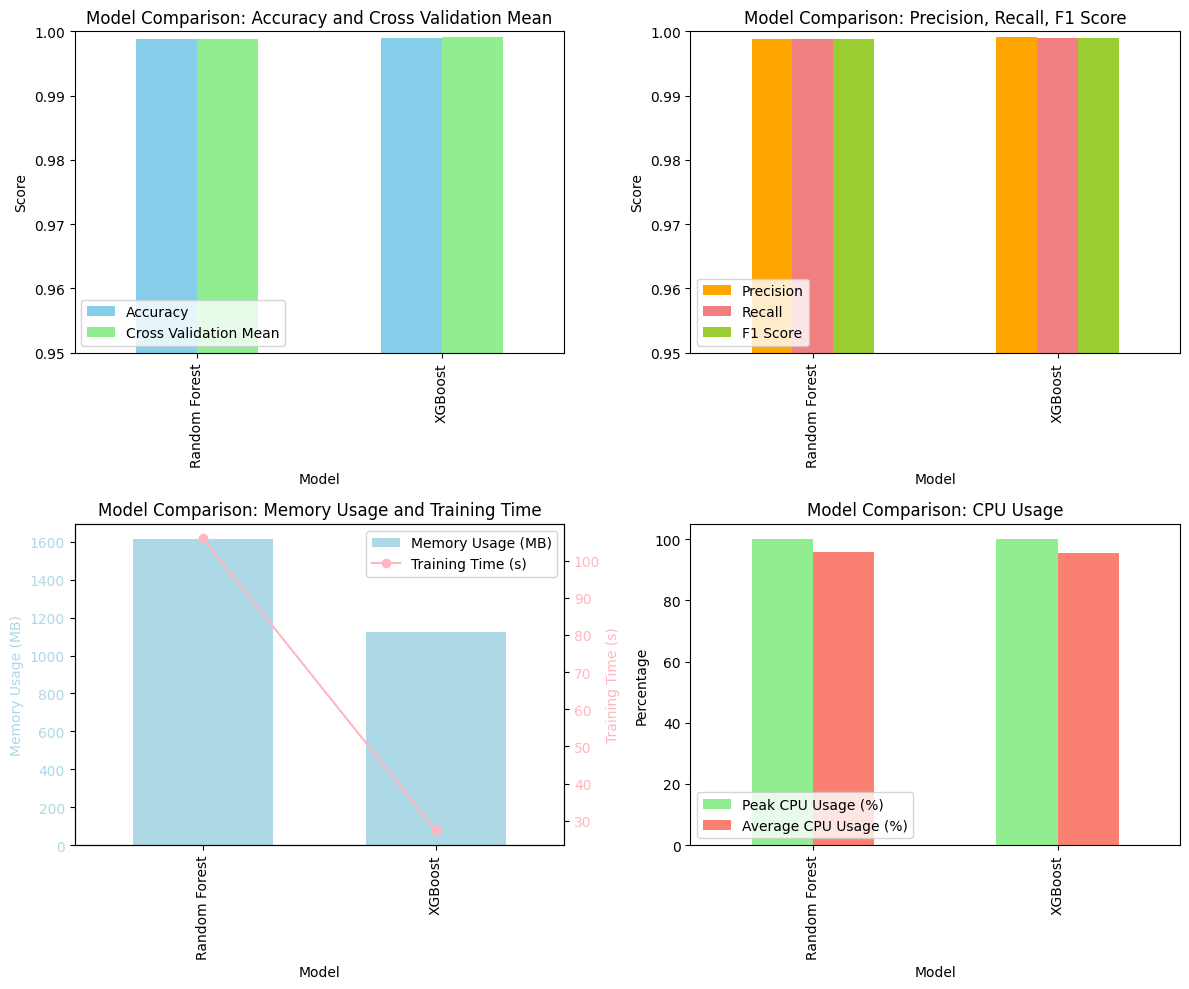

In [79]:
# Plotting the comparison for accuracy, cross-validation, and metrics
fig, axes = plt.subplots(2, 2, figsize=(12, 10))

# Plotting Accuracy and Cross Validation Mean
supervised_results.set_index('Model')[['Accuracy', 'Cross Validation Mean']].plot(kind='bar', ax=axes[0, 0], color=['skyblue', 'lightgreen'], legend=True)
axes[0, 0].set_title('Model Comparison: Accuracy and Cross Validation Mean')
axes[0, 0].set_ylabel('Score')
axes[0, 0].set_xlabel('Model')
axes[0, 0].set_ylim(0.95, 1.0)
axes[0, 0].legend(loc='lower left')

# Plotting Precision, Recall, F1 Score
supervised_results.set_index('Model')[['Precision', 'Recall', 'F1 Score']].plot(kind='bar', ax=axes[0, 1], color=['orange', 'lightcoral', 'yellowgreen'], legend=True)
axes[0, 1].set_title('Model Comparison: Precision, Recall, F1 Score')
axes[0, 1].set_ylabel('Score')
axes[0, 1].set_xlabel('Model')
axes[0, 1].set_ylim(0.95, 1.0)
axes[0, 1].legend(loc='lower left')

# Plotting Memory Usage and Training Time
ax1 = axes[1, 0]

supervised_results.set_index('Model')['Memory Usage (MB)'].plot(
    kind='bar', ax=ax1, color='lightblue', label='Memory Usage (MB)', width=0.6
)
ax1.set_ylabel('Memory Usage (MB)', color='lightblue')
ax1.tick_params(axis='y', labelcolor='lightblue')

ax2 = ax1.twinx() 
supervised_results.set_index('Model')['Training Time (s)'].plot(
    ax=ax2, color='lightpink', marker='o', label='Training Time (s)'
)
ax2.set_ylabel('Training Time (s)', color='lightpink')
ax2.tick_params(axis='y', labelcolor='lightpink')

ax1.set_title('Model Comparison: Memory Usage and Training Time')
ax1.set_xlabel('Model')

lines, labels = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines + lines2, labels + labels2, loc='upper right')

# Plotting Peak and Average CPU Usage
supervised_results.set_index('Model')[['Peak CPU Usage (%)', 'Average CPU Usage (%)']].plot(kind='bar', ax=axes[1, 1], color=['lightgreen', 'salmon'], legend=True)
axes[1, 1].set_title('Model Comparison: CPU Usage')
axes[1, 1].set_ylabel('Percentage')
axes[1, 1].set_xlabel('Model')
axes[1, 1].legend(loc='lower left')

plt.tight_layout()
plt.show()

In [86]:
# Select the best model based on Recall
best_row = supervised_results.loc[supervised_results['Recall'].idxmax()]
best_model_name = best_row['Model']
best_recall = best_row['Recall']

print(f"Best model based on Recall: {best_model_name} with Recall = {best_recall * 100:.2f}%")
print(best_row)


Best model based on Recall: XGBoost with Recall = 99.90%
Model                        XGBoost
Accuracy                    0.998974
Cross Validation Mean        0.99912
Precision                   0.999064
Recall                      0.998974
F1 Score                    0.999003
Memory Usage (MB)        1123.046875
Training Time (s)          27.348724
Peak CPU Usage (%)             100.0
Average CPU Usage (%)      95.442471
Name: 1, dtype: object


In [81]:
if best_model_name == "Random Forest":
    final_model = rf_model
elif best_model_name == "XGBoost":
    final_model = xgb_model
else:
    raise ValueError("Best model not recognized!")


In [84]:

joblib.dump(final_model, "../models/best_model_recall.joblib")

['../models/best_model_recall.joblib']